In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

2024-05-23 22:57:34.207486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 22:57:35.746687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Obtenção dos Dados

In [2]:
DIR = './data'
CLASS = {'Cars':0, 'Drones': 1, 'People':2}

list_of_file = []   # filename/details
list_of_img = []    # x
list_of_classi = [] # y

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.endswith('.csv'):
            tmp = root.strip().split('/')
            if tmp[-2] in CLASS:
                list_of_classi.append(CLASS[tmp[-2]])
                list_of_file.append(os.path.join('/'.join(tmp[-3:]),file))
                df = pd.read_csv(os.path.join(root,file))
                list_of_img.append(df.values)

X = np.array(list_of_img)
y = np.array(list_of_classi)
d = np.array(list_of_file)
                
print(len(list_of_file), 'files loaded.')

34970 files loaded.


### Exploração dos Dados

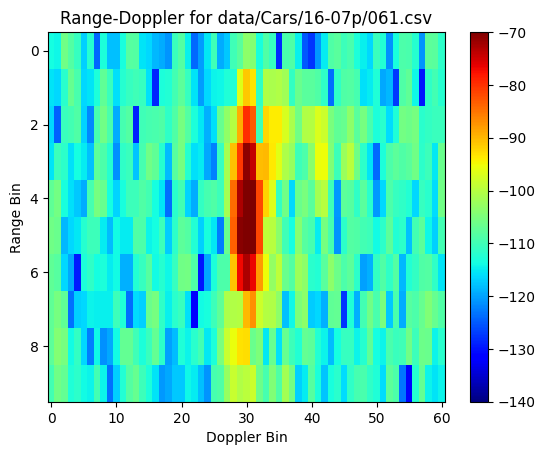

In [3]:
fig = plt.figure()
ax = plt.axes()
img = ax.imshow(list_of_img[0], vmin=-140, vmax=-70, cmap='jet')
plt.title('Range-Doppler for {}'.format(list_of_file[0]))
plt.axis('tight')
plt.ylabel('Range Bin')
plt.xlabel('Doppler Bin')
plt.colorbar(img)
plt.show()

### Transformação dos Dados

In [4]:
X = X.reshape(-1, 10, 61, 1)

In [5]:
y = to_categorical(y)

In [6]:
X_train, _X, y_train, _y = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(_X, _y, test_size=0.5, random_state=42)

### A) Modelo Classificador (Rede Neural Convolucional)

In [7]:
from keras.layers import Input, BatchNormalization, Conv2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import MaxPooling2D
from keras.layers import LeakyReLU
from keras.models import Model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from seaborn import heatmap


from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D
import numpy as np
import tensorflow as tf

In [8]:
def make_cnn(img_cols, img_rows):

    input_image = Input(shape=(img_cols, img_rows, 1))

    # Layer 1
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_1', use_bias=False)(input_image)
    layer = BatchNormalization(name='norm_1')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_1')(layer)

    # Layer 2
    layer = Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_2', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_2')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_2')(layer)

    # Layer 3
    layer = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', name='conv_3', use_bias=False)(layer)
    layer = BatchNormalization(name='norm_3')(layer)
    layer = LeakyReLU(alpha=0.1, name='leaky_relu_3')(layer)
    layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='max_pool_3')(layer)

    layer = Flatten()(layer)
    layer = Dense(64, activation='relu')(layer)
    layer = Dense(3, activation='softmax')(layer)

    model = Model(inputs=input_image, outputs=layer, name='CNN')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [10]:
model = make_cnn(10, 61)

2024-05-23 22:59:36.217040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:59:36.449794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:59:36.449876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:59:36.453604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:65:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-23 22:59:36.453694: I tensorflow/compile

In [11]:
_ = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


2024-05-23 22:59:45.526420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-05-23 22:59:48.571938: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-23 22:59:52.238728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-23 22:59:52.289862: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9bd401ede0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 22:59:52.289947: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-05-23 22:59:52.387161: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 22:59:52.80232

383/383 [==============================] - 21s 15ms/step - loss: 0.2755 - accuracy: 0.8995 - val_loss: 0.2919 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 2/10
383/383 [==============================] - 4s 11ms/step - loss: 0.1411 - accuracy: 0.9482 - val_loss: 0.1786 - val_accuracy: 0.9390 - lr: 0.0010
Epoch 3/10
383/383 [==============================] - 4s 12ms/step - loss: 0.1109 - accuracy: 0.9605 - val_loss: 0.2804 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 4/10
383/383 [==============================] - 4s 12ms/step - loss: 0.0942 - accuracy: 0.9660 - val_loss: 0.1130 - val_accuracy: 0.9561 - lr: 0.0010
Epoch 5/10
383/383 [==============================] - 5s 12ms/step - loss: 0.0803 - accuracy: 0.9708 - val_loss: 0.1434 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 6/10
383/383 [==============================] - 5s 12ms/step - loss: 0.0703 - accuracy: 0.9745 - val_loss: 0.1259 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 7/10
383/383 [==============================] - 4s 11ms/step - loss:

In [12]:
y_pred = model.predict(X_test, verbose=0)

In [14]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.97      0.86      0.91      1710
      Drones       0.88      0.97      0.92      1526
      People       0.97      1.00      0.98      2010

    accuracy                           0.94      5246
   macro avg       0.94      0.94      0.94      5246
weighted avg       0.94      0.94      0.94      5246



[]

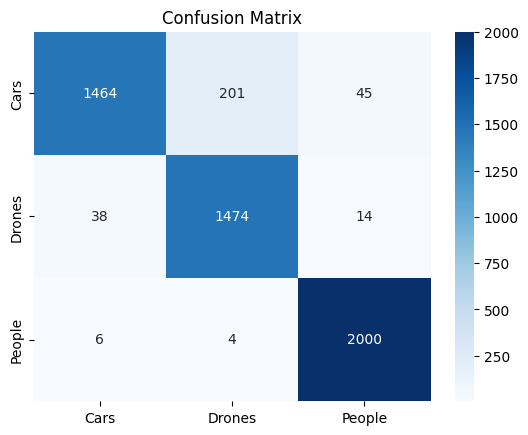

In [15]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

### B) Transfer Learning

In [24]:
def ajust_image(images):
    images = tf.tile(images, [1, 1, 1, 3])
    return tf.image.resize(images, [224, 224], method='bilinear')

In [25]:
input_tensor = Input(shape=(10, 61, 1))
input_tensor = Lambda(ajust_image)(input_tensor)

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_tensor,
)

80134624/80134624 [==============================] - 5s 0us/step


In [26]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
for layer in base_model.layers:
    layer.trainable = False

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
_ = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


2024-05-23 23:27:50.650389: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:27:50.666548: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:27:50.684235: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:27:50.684330: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

383/383 [==============================] - ETA: 0s - loss: 0.6051 - accuracy: 0.7368

2024-05-23 23:29:01.386409: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:29:01.401485: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:29:01.419836: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-23 23:29:01.419932: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU

383/383 [==============================] - 73s 184ms/step - loss: 0.6051 - accuracy: 0.7368 - val_loss: 0.4720 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 2/10
383/383 [==============================] - 67s 176ms/step - loss: 0.4561 - accuracy: 0.8055 - val_loss: 0.4413 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 3/10
383/383 [==============================] - 68s 177ms/step - loss: 0.4282 - accuracy: 0.8176 - val_loss: 0.4199 - val_accuracy: 0.8097 - lr: 0.0010
Epoch 4/10
383/383 [==============================] - 68s 177ms/step - loss: 0.4297 - accuracy: 0.8133 - val_loss: 0.4601 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 5/10
383/383 [==============================] - 68s 177ms/step - loss: 0.4068 - accuracy: 0.8258 - val_loss: 0.4845 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 6/10
383/383 [==============================] - 67s 176ms/step - loss: 0.4008 - accuracy: 0.8245 - val_loss: 0.4820 - val_accuracy: 0.7973 - lr: 0.0010
Epoch 7/10
383/383 [==============================] - 67s 176ms

In [31]:
y_pred = model.predict(X_test, verbose=0)

In [32]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.67      0.85      0.75      1710
      Drones       0.79      0.61      0.69      1526
      People       0.98      0.92      0.95      2010

    accuracy                           0.81      5246
   macro avg       0.81      0.79      0.79      5246
weighted avg       0.82      0.81      0.81      5246



[]

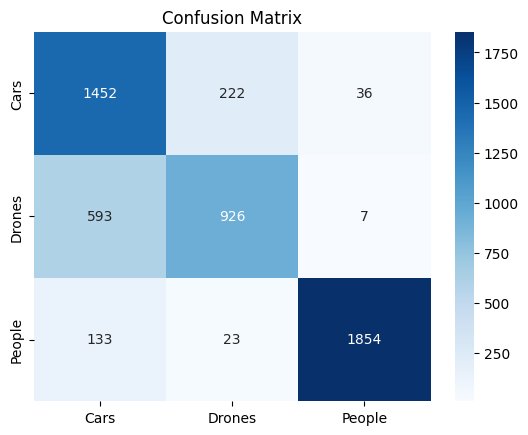

In [33]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()

### C) Fining Tunning

In [34]:
for layer in base_model.layers:
    layer.trainable = True

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
_ = model.fit(
    X_train,
    y_train,
    epochs=1,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

383/383 [==============================] - 186s 438ms/step - loss: 125.6526 - accuracy: 0.3697 - val_loss: 1.0908 - val_accuracy: 0.3823 - lr: 0.0010


In [37]:
y_pred = model.predict(X_test, verbose=0)

In [38]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASS.keys()))

              precision    recall  f1-score   support

        Cars       0.00      0.00      0.00      1710
      Drones       0.00      0.00      0.00      1526
      People       0.38      1.00      0.55      2010

    accuracy                           0.38      5246
   macro avg       0.13      0.33      0.18      5246
weighted avg       0.15      0.38      0.21      5246



/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lucas/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[]

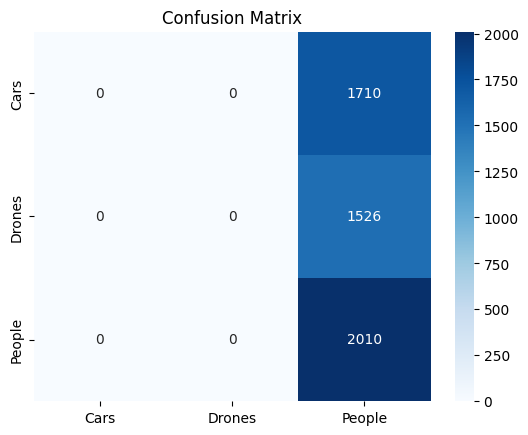

In [39]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS.keys(), yticklabels=CLASS.keys())

plt.title('Confusion Matrix')

plt.plot()